In [115]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

In [116]:
# load final clean dataset

df = pd.read_csv('merged_clean_data.csv')

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77938 entries, 0 to 77937
Data columns (total 34 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   provincename                                                                       77938 non-null  object 
 1   Longitude                                                                          77938 non-null  float64
 2   Latitude                                                                           77938 non-null  float64
 3   Region.Name                                                                        77938 non-null  object 
 4   Date/Time                                                                          77938 non-null  object 
 5   Utilities                                                                          70102 non-null  flo

In [118]:
# convert 'Date/Time' to datetime format

df['Date/Time'] = pd.to_datetime(df['Date/Time'])

# convert 'GeoUID' to string

df['GeoUID'] = df['GeoUID'].astype('str')

In [119]:
# set date time as index
df.set_index('Date/Time', inplace = True)

All 5 provinces

In [120]:
# split data into numeric and string
num_cols = df.select_dtypes(include = ['number'])
cat_cols = df.select_dtypes(include = ['object'])

# resample numeric data
resampled_num = num_cols.resample("M").mean()

# resample string data
resampled_cat = cat_cols.resample('M').apply(lambda x: x.value_counts().idxmax())

# combine resampled data
resampled_data_M = pd.concat([resampled_num, resampled_cat], axis = 1)
print(type(resampled_data_M))

# resampled_data = df.resample('M').mean()
# print(resampled_data)

<class 'pandas.core.frame.DataFrame'>


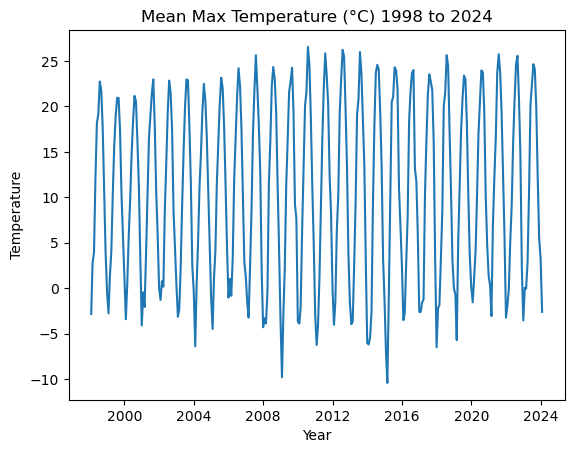

In [121]:
# plot mean max temp
plt.plot(resampled_data_M['Mean Max Temp (°C)'])
plt.title('Mean Max Temperature (°C) 1998 to 2024')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.show()

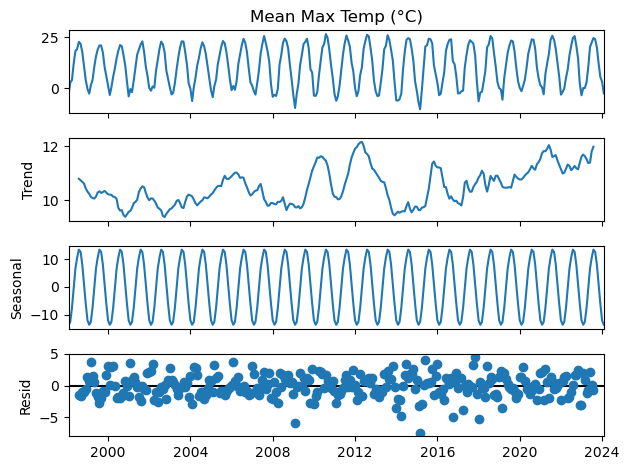

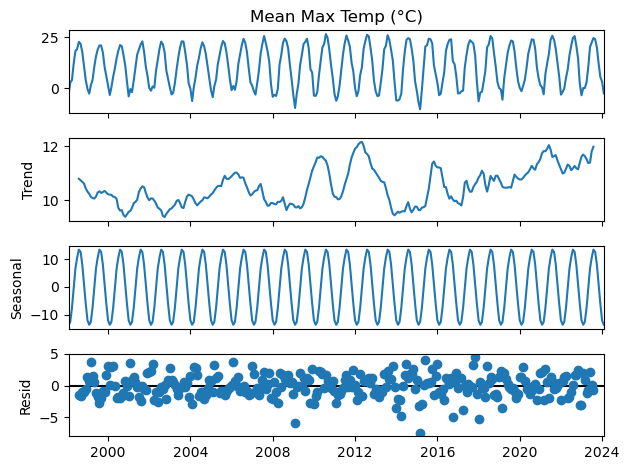

In [122]:
# seasonal decompose to separate different components (trend, seasonality, and residual)

decomp = seasonal_decompose(resampled_data_M['Mean Max Temp (°C)'],
                            period = 12)

decomp.plot()

<Axes: xlabel='Date/Time'>

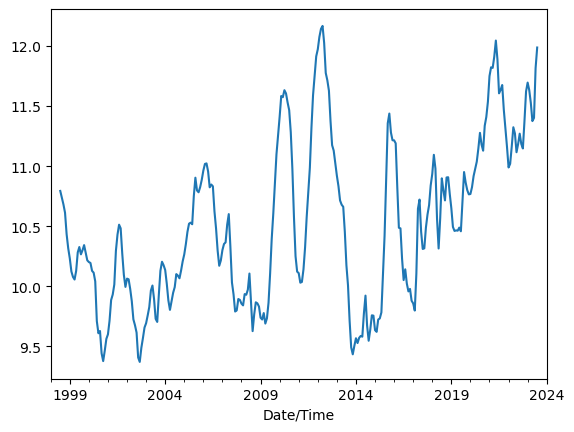

In [123]:
decomp.trend.plot()

<Axes: xlabel='Date/Time'>

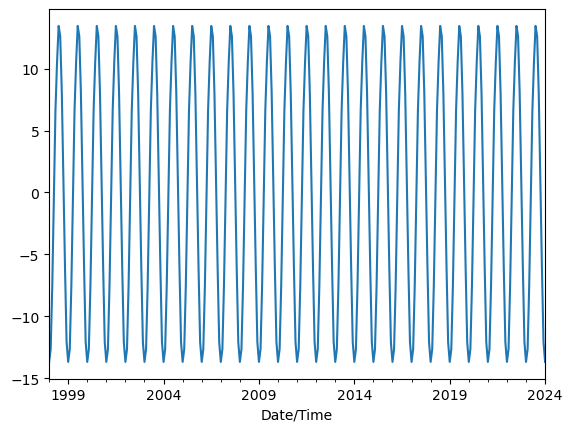

In [124]:
decomp.seasonal.plot()

<Axes: xlabel='Date/Time'>

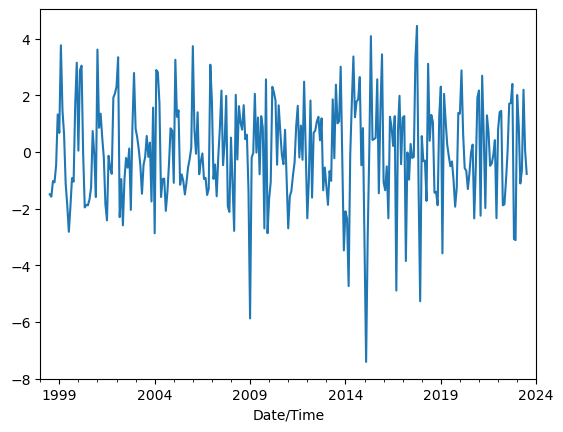

In [125]:
decomp.resid.plot()

Dicky-Fuller test

In [126]:
adfuller_result = adfuller(resampled_data_M['Mean Max Temp (°C)'])
test_statistic, p_value, num_lags, num_obs, critical_values, aic = adfuller_result
print(adfuller_result)

# Print ADF test result along with elements
print(f"ADF Test Result:")
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")
print(f"Number of Lags: {num_lags}")
print(f"Number of Observations: {num_obs}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"  {key}: {value}")
print(f"Estimated maximized information criterion (aic): {aic}")

(-3.572539236030685, 0.006308248779781542, 16, 296, {'1%': -3.452636878592149, '5%': -2.8713543954331433, '10%': -2.5719993576515705}, 1226.7813956569635)
ADF Test Result:
Test Statistic: -3.572539236030685
P-value: 0.006308248779781542
Number of Lags: 16
Number of Observations: 296
Critical Values:
  1%: -3.452636878592149
  5%: -2.8713543954331433
  10%: -2.5719993576515705
Estimated maximized information criterion (aic): 1226.7813956569635


ACF and PACF

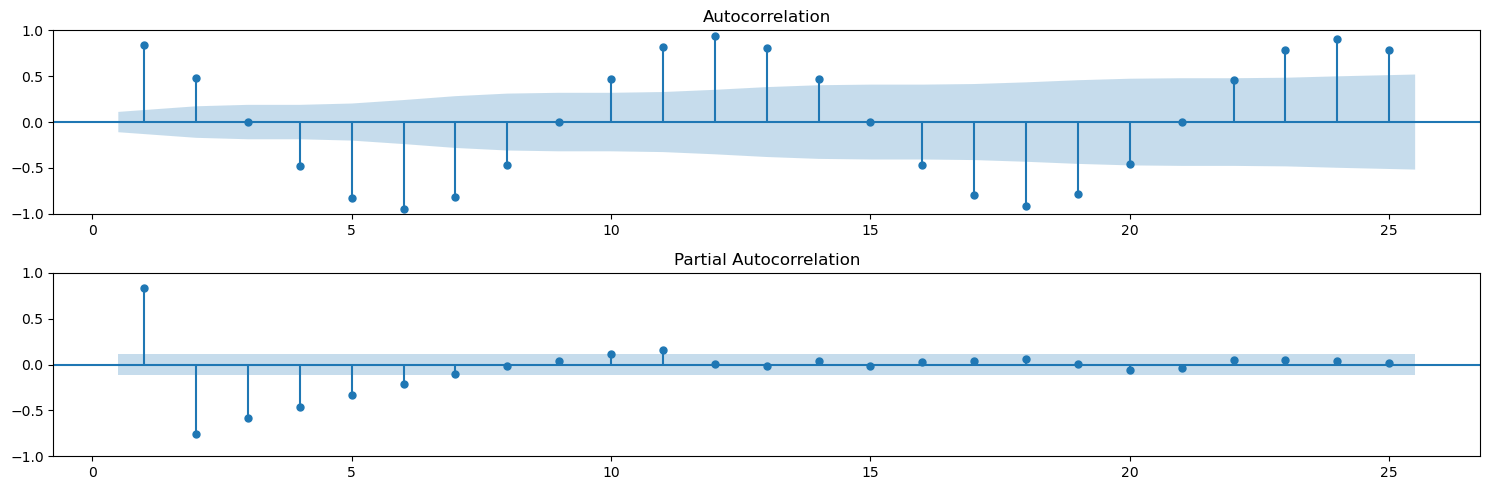

In [127]:
# create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (15, 5))

# plot acf
plot_acf(resampled_data_M['Mean Max Temp (°C)'], zero = False, ax = ax1)

# plot pacf
plot_pacf(resampled_data_M['Mean Max Temp (°C)'],   zero = False, ax = ax2)

plt.tight_layout()
plt.show()

ARIMA model

In [128]:
# Create empty list to store search results
order_aic_bic=[]
# Loop over p values from 0-4 (Use the partial autocorrelation)
for p in range(5):
# Loop over q values from 0-4 (Use the autocorrelation)
    for q in range(5):
        try:
            # Create and fit ARIMA(p,d,q) model
            model = sm.tsa.ARIMA(resampled_data_M['Mean Max Temp (°C)'], order=(p,0,q), trend='c')
            results = model.fit()
            # Append order and results tuple
            order_aic_bic.append((p,q,results.aic, results.bic))
        except:
            print(p, q, None, None)

c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\t

In [129]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic,
                        columns=['p', 'q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC'))

# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC'))

    p  q          AIC          BIC
13  2  3  1290.124450  1316.347872
22  4  2  1292.955578  1322.925203
17  3  2  1293.177881  1319.401304
23  4  3  1293.999393  1327.715221
12  2  2  1296.300248  1318.777467
14  2  4  1298.351242  1328.320867
18  3  3  1298.512326  1328.481951
24  4  4  1304.531630  1341.993662
19  3  4  1306.936793  1340.652622
21  4  1  1367.515940  1393.739362
16  3  1  1393.950876  1416.428095
20  4  0  1423.547617  1446.024837
11  2  1  1436.929680  1455.660696
15  3  0  1512.463567  1531.194583
10  2  0  1637.381445  1652.366258
4   0  4  1718.075567  1740.552787
7   1  2  1760.379744  1779.110760
9   1  4  1761.379585  1787.603007
3   0  3  1781.205601  1799.936617
6   1  1  1818.663351  1833.648164
8   1  3  1858.121507  1880.598726
2   0  2  1871.526488  1886.511301
5   1  0  1943.282386  1954.520996
1   0  1  2033.283640  2044.522250
0   0  0  2330.172568  2337.664974
    p  q          AIC          BIC
13  2  3  1290.124450  1316.347872
12  2  2  1296.30024

In [130]:
#to check the minimum value in the dataframe
order_df.AIC.min()

1290.1244501143124

In [131]:
#to check the minimum value in the dataframe
order_df.BIC.min()

1316.3478724480935

In [132]:
# Instantiate the model
#model = sm.tsa.ARIMA(milk_prod_diff, order=(9, 0, 4)) #order=(p,d,q)

model = sm.tsa.ARIMA(resampled_data_M['Mean Max Temp (°C)'], order=(2, 1, 3)) #order=(p,d,q)

# Fit the model
results = model.fit()

# Print model fit summary
print(results.summary())

c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:     Mean Max Temp (°C)   No. Observations:                  313
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -643.425
Date:                Sun, 17 Mar 2024   AIC                           1298.851
Time:                        15:16:02   BIC                           1321.309
Sample:                    01-31-1998   HQIC                          1307.827
                         - 01-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7320      0.001   1872.896      0.000       1.730       1.734
ar.L2         -0.9997      0.001  -1334.959      0.000      -1.001      -0.998
ma.L1         -2.6098      0.048    -54.018      0.0

Split data to train and test dataset

In [133]:
# split data to train and test

train = resampled_data_M.loc[resampled_data_M.index <= '2022-01-01']
test = resampled_data_M.loc[resampled_data_M.index > '2022-01-01']

In [134]:
#to fit the model after splitting the data

# Instantiate the model
model = sm.tsa.ARIMA(train['Mean Max Temp (°C)'], order=(2, 1, 3)) #order=(p,d,q)

# Fit the model
results_1 = model.fit()


c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [135]:
#get the predictions
predictions = results_1.get_forecast(steps=36)
# Extract prediction mean
mean_predictions =predictions.predicted_mean

In [136]:
mean_predictions

2022-01-31    -3.242229
2022-02-28    -1.782108
2022-03-31     2.954564
2022-04-30     9.698312
2022-05-31    16.642701
2022-06-30    21.928218
2022-07-31    24.140202
2022-08-31    22.687474
2022-09-30    17.960335
2022-10-31    11.225706
2022-11-30     4.287584
2022-12-31    -0.996198
2023-01-31    -3.211442
2023-02-28    -1.766092
2023-03-31     2.951526
2023-04-30     9.677041
2023-05-31    16.608898
2023-06-30    21.890939
2023-07-31    24.109431
2023-08-31    22.671447
2023-09-30    17.963338
2023-10-31    11.246929
2023-11-30     4.321337
2023-12-31    -0.958957
2024-01-31    -3.180686
2024-02-29    -1.750055
2024-03-31     2.948557
2024-04-30     9.655866
2024-05-31    16.575194
2024-06-30    21.853736
2024-07-31    24.078690
2024-08-31    22.655398
2024-09-30    17.966273
2024-10-31    11.268055
2024-11-30     4.354990
2024-12-31    -0.921792
Freq: M, Name: predicted_mean, dtype: float64

In [137]:
test['Mean Max Temp (°C)']#.loc['2022-01-31':'2024-12-31']

Date/Time
2022-01-31    -1.902235
2022-02-28    -0.220802
2022-03-31     5.097507
2022-04-30     9.034053
2022-05-31    16.039724
2022-06-30    20.649357
2022-07-31    24.658194
2022-08-31    25.576209
2022-09-30    20.971759
2022-10-31    14.621617
2022-11-30     2.275261
2022-12-31    -3.565782
2023-01-31     0.030103
2023-02-28    -0.067712
2023-03-31     2.896828
2023-04-30    10.324771
2023-05-31    20.216312
2023-06-30    22.415759
2023-07-31    24.656140
2023-08-31    24.081518
2023-09-30    19.889953
2023-10-31    12.078007
2023-11-30     5.460168
2023-12-31     3.200644
2024-01-31    -2.620875
Freq: M, Name: Mean Max Temp (°C), dtype: float64

In [140]:
# to calculate MAPE and RSME
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

arima_MAE = mean_absolute_error(test['Mean Max Temp (°C)'].loc['2022-01-31':'2024-01-31'], mean_predictions.loc['2022-01-31':'2024-01-31'])
print('Arima_MAE:', arima_MAE)

arima_MAPE = mean_absolute_percentage_error(test['Mean Max Temp (°C)'].loc['2022-01-31':'2024-01-31'], mean_predictions.loc['2022-01-31':'2024-01-31'])
print('Arima_MAPE:', arima_MAPE)

arima_RMSE = np.sqrt(mean_squared_error(test['Mean Max Temp (°C)'].loc['2022-01-31':'2024-01-31'], mean_predictions.loc['2022-01-31':'2024-01-31']))
print('Arima_RMSE:', arima_RMSE)


Arima_MAE: 1.6933445283270208
Arima_MAPE: 5.819959298273046
Arima_RMSE: 2.038017014785312


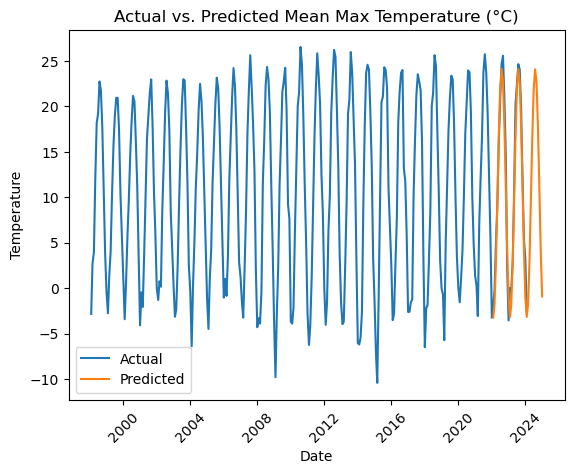

In [ ]:
# plot actual data and predictions

plt.plot(resampled_data_M.index, resampled_data_M['Mean Max Temp (°C)'], label='Actual')

# Assuming mean_predictions is a Series or list of predicted values with corresponding dates
# Plot predicted values
plt.plot(mean_predictions.index, mean_predictions.values, label='Predicted')

plt.title('Actual vs. Predicted Mean Max Temperature (°C)')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.xticks(rotation=45)

plt.show()